# Implementación de moldelo de deep learning
## Primer modelo: No muy eficiente

### Mariluz Daniela Sánchez Morales - A01422953

> **Caso**: Clasificación de enfermedades comunes del tórax.
>
> **Dataset**: [NIH Chest X-rays de Kaggle](https://www.kaggle.com/datasets/nih-chest-xrays/data "Link a Kaggle")

### **Desarrollo del Problema**: Detección de Enfermedades en Radiografías Torácicas con Deep Learning

La interpretación de radiografías torácicas es una tarea crucial en el diagnóstico médico, sin embargo, la detección precisa de estas enfermedades en las imágenes de rayos X presenta grandes desafíos debido a que muchos de estos signos patológicos suelen sobreponerse sobre otros. La interpretación de estas radiografías deben ser interpretadas por radiólogos expertos; sin embargo, día a día la demanda de exámenes radiológicos crece y uno de los desafíos es la poca disponibilidad o falta de especialistas en radiología por lo existe la necesidad de buscar tecnologías para solucionar esta escasez en el sector de la salud.

El objetivo de este proyecto es crear un modelo de deep learning que ayude a detectar automáticamente posibles enfermedades que puedan aparecer en radiografías torácicas proporcionando un “filtro preliminar” para identificar casos con alta probabilidad de alguna de las enfermedades comunes encontradas en el tórax. La automatización de esta tarea puede significar un gran apoyo en el área médica para la detección de anomalías en los casos que se presente.

Para este proyecto, se utilizó el NIH Chest X-ray Dataset de Kaggle, un conjunto de datos público que contiene más de 112,000 imágenes de rayos X etiquetadas con 14 tipos de enfermedades pulmonares y a su vez también clasifica casos donde no se encuentre enfermedad.

# Objetivo

Este código establece el flujo básico de trabajo: carga de datos, preprocesamiento de las imágenes y etiquetas, diseño de una red neuronal convolucional simple, y entrenamiento del modelo.Aunque esta primera versión tiene un desempeño limitado (accuracy de 0.42), sirve como una base inicial para identificar áreas de mejora en la clasificación de condiciones médicas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Carga de datos

Se carga en un DataFrame de Pandas el archivo CSV que contiene el nombre de las imágenes y las etiquetas con las enfermedades que les fueron asignadas. 

Después, se lista el contenido del directorio de imágenes para verificar qué archivos están realmente disponibles en el sistema. Y finalmente se filtra el DataFrame para asegurarse de trabajar solo con las imágenes existentes, evitando errores en el proceso de carga de datos.

Esta filtración de datos se hizo debido a la limitación de procesamiento computacional ya que el tamaño total del dataset es de 112,120 imágenes.

In [2]:
import os
import pandas as pd

# Cargar el CSV en un DataFrame
df = pd.read_csv('Data_Entry_2017.csv')

# Listar los archivos de imagen disponibles en el directorio
available_images = set(os.listdir('images_001/images'))  # Crear un conjunto con los nombres de archivos

# Filtrar el DataFrame para mantener solo las imágenes que existen en el directorio
df = df[df['Image Index'].isin(available_images)]

# Comprobar el resultado
print("Número de imágenes disponibles después del filtrado:", len(df))


Número de imágenes disponibles después del filtrado: 4999


# Generación de Datos con Aumento para Entrenamiento y Validación

Para mejorar el rendimiento del modelo, se preprocesan las imagenes usando ImageDataGenerator para normalizar los valores de los píxeles de las imágenes, de modo que en lugar de estar entre 0 y 255, estarán entre 0 y 1.

Tambié se divide el conjunto de datos en un 80% para entrenamiento y 20% para validación.
Se configuran generadores de datos para alimentar el modelo en lotes de 32 imágenes con un tamaño de 224x224 píxeles. 
El tipo de clasificación es categórico ya que se espera clasificar entre múltiples clases.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # 20% para validación
)

train_data = data_gen.flow_from_dataframe(
    dataframe=df,
    directory='images_Test/images',
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = data_gen.flow_from_dataframe(
    dataframe=df,
    directory='images_Test/images',
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4000 validated image filenames belonging to 15 classes.
Found 999 validated image filenames belonging to 15 classes.


# Construcción del Modelo

Este primer modelo se basa en una arquitectura de red neuronal convolucional (CNN) que se alterna con capas tanto de convolución como de max-pooling, que en este caso lo que se espera es que permita detectar características espaciales en las imágenes de rayos X.

Tambien se usa un Dropout para reducir el sobreajuste; su funci+on es desconectar de forma aleatoria fracciones de la red durante el entrenamiento, para que se contruya un modelo robusto y confiable. 

La capa de salida es una capa densa con 15 neuronas y activación softmax, correspondiente a las 14 clases de enfermedades y una clase adicional para las imágenes sin enfermedad.

## Compilación del Modelo

De igual forma en esta seccion se compila el modelo usando el optimizador Adam, esto para asegurar que los pesos del modelo se ajusten de manera óptima con el fin de reducir la función de pérdida.

La función de pérdida utilizada es categorical_crossentropy, que en este caso sirve para la clasificacion multiclase asignando probabilidades de clases donde la suma de todas es 1. 

Finalmente el modelo evalúa su rendimiento con la métrica de accuracy.

In [ ]:
# Crear el modelo base
model = models.Sequential([
    # Capas convolucionales
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Capa aplanada y capas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Capa de salida para clasificación multiclase
    layers.Dense(15, activation='softmax')  # 15 neuronas para 14 clases de enfermedades y 1 sin enfermedad
])

# Compilar el modelo para multiclase
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Para clasificación multiclase
              metrics=['accuracy'])

model.summary()

c:\Users\z47al\miniconda3\envs\ml_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Verificar las etiquetas generadas por el generador de datos
x_batch, y_batch = next(train_data)
print("Forma de las entradas (imágenes):", x_batch.shape)
print("Forma de las etiquetas (one-hot):", y_batch.shape)


Forma de las entradas (imágenes): (32, 224, 224, 3)
Forma de las etiquetas (one-hot): (32, 15)


# Entrenamiento del Modelo

Se entrena el modelo con los datos de entrenamiento, por un total de 10 épocas. El proceso de entrenamiento se lleva a cabo en paralelo con el conjunto de validación, lo que permite monitorear el rendimiento del modelo en datos no vistos.

De igual forma por la limitación de procesamiento, los periodos de entrenamiento son bajos.

In [6]:
# Entrenar el modelo
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

c:\Users\z47al\miniconda3\envs\ml_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 975ms/step - accuracy: 0.5089 - loss: 2.4559 - val_accuracy: 0.4254 - val_loss: 2.1929
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 963ms/step - accuracy: 0.5758 - loss: 1.7462 - val_accuracy: 0.4254 - val_loss: 2.1150
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5856 - loss: 1.6808 - val_accuracy: 0.4254 - val_loss: 2.0795
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5684 - loss: 1.6860 - val_accuracy: 0.4254 - val_loss: 2.0220
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 998ms/step - accuracy: 0.5647 - loss: 1.6751 - val_accuracy: 0.4254 - val_loss: 2.0588
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 940ms/step - accuracy: 0.5650 - loss: 1.6738 - val_accuracy: 0.4254 - val_loss: 2.0386
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 905ms/step - accuracy: 0.5724 - loss: 1.6043 - val_accuracy: 0.4254 - val_loss: 2.0520
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 947ms/step - accuracy: 0.5928 - loss:

# Visualización de resultados

La precisión y la pérdida a lo largo de las épocas se visualizan en gráficos. Estos gráficos permiten evaluar el progreso y la consistencia del modelo en entrenamiento y validación. La curva de precisión muestra el ajuste del modelo, mientras que la curva de pérdida indica posibles problemas de sobreajuste si diverge en validación.

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step - accuracy: 0.4070 - loss: 2.1468
Validation Accuracy: 0.43
Validation Loss: 2.09


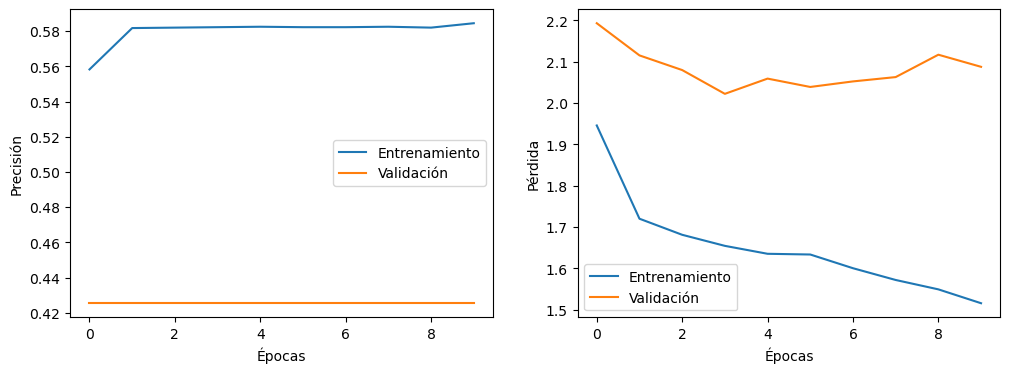

In [7]:
# Obtener resultados de validación
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

# Visualizar la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Conclusión

Este primer modelo proporciona un punto de partida en el uso de redes neuronales convolucionales para la detección de enfermedades en radiografías de tórax.

Con una precisión de 0.42, los resultados indican que la arquitectura no es lo suficientemente compleja para capturar las variaciones en las características de las enfermedades. Este primer intento destaca la necesidad de un modelo más robusto y especializado para abordar la complejidad de este problema clínico.